# Corruption network

## Packages and libraries

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Third Party Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
from operator import itemgetter
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

#Networks
import networkx as nx

In [9]:
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
              'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'ytick.left': 'on',
              'xtick.bottom': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in"
              }
    mpl.rcParams.update(rcparams) 

stdrcparams(usetex=True)
figsize=stdfigsize()
print(figsize)

(9.1, 7)


/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [10]:
def moving_average(a, n=3):
    """
    Calculates the moving average over an array.
    Parameters
    ----------
    a: array   
    n: windows size (default = 3)
    ----------
    Returns the moving average of a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pdf(data, nbins=15, log=False, symmetrical=False):
    """
    Estimates the pdf from a np.array.
    Parameters
    ----------
    data: np.array
    nbins: number of bins or np.histogram method name (Default: 15).
    log: True for log-spaced bins (Default: False).
    symmetrical: True for symmetrical bin interval (Default: False).
    ----------
    Returns [bins,pdf].
    """
    if not isinstance(nbins, str):
        if log:
            if symmetrical:
                maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
                bins = np.logspace(-maxdata, maxdata, nbins)
            else:
                bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
        else:
            if symmetrical:
                maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
                bins = np.linspace(-maxdata, maxdata, nbins)
            else:
                bins = np.linspace(np.min(data), np.max(data), nbins)
    else:
        bins = nbins
    densities, bbins = np.histogram(data, bins=bins, density=True)
    return moving_average(bbins, 2), densities


def cdf(data, nbins=15, log=False, surv=True):
    """
    Estimates the survival distribution from a np.array.
    Parameters
    ----------
    data: np.array
    nbins: number of bins.
    log: True for log-spaced bins (Default: False).
    surv: False for cumulative distribution function (Default: True).
    ----------
    Returns [bins,pdf].
    """
    size = len(data)
    if log:
        bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        bins = np.linspace(np.min(data), np.max(data),nbins)        
    densities = np.array([len(data[data>=binvalue])/size for binvalue in bins])
    if not surv:
        densities = 1 - densities
    return bins, densities

# Demography corruption network

- HV Ribeiro, LGA Alves, AF Martins, EK Lenzi, M Perc. The dynamical structure of political corruption networks. Journal of Complex Networks CNY002 1-15 (2018).

In [11]:
df_size=pd.read_csv("data/scandalssize.csv",index_col=0)

In [12]:
df_size.head()

,scandal,year,size
0,Caso Banespa,1987,4
1,Ferrovia Norte-Sul,1987,2
2,CPI da Corrupção,1988,3
3,Máfia da Previdência,1991,3
4,Caso Collor,1992,11


Text(0.5, 0, 'Scandals')

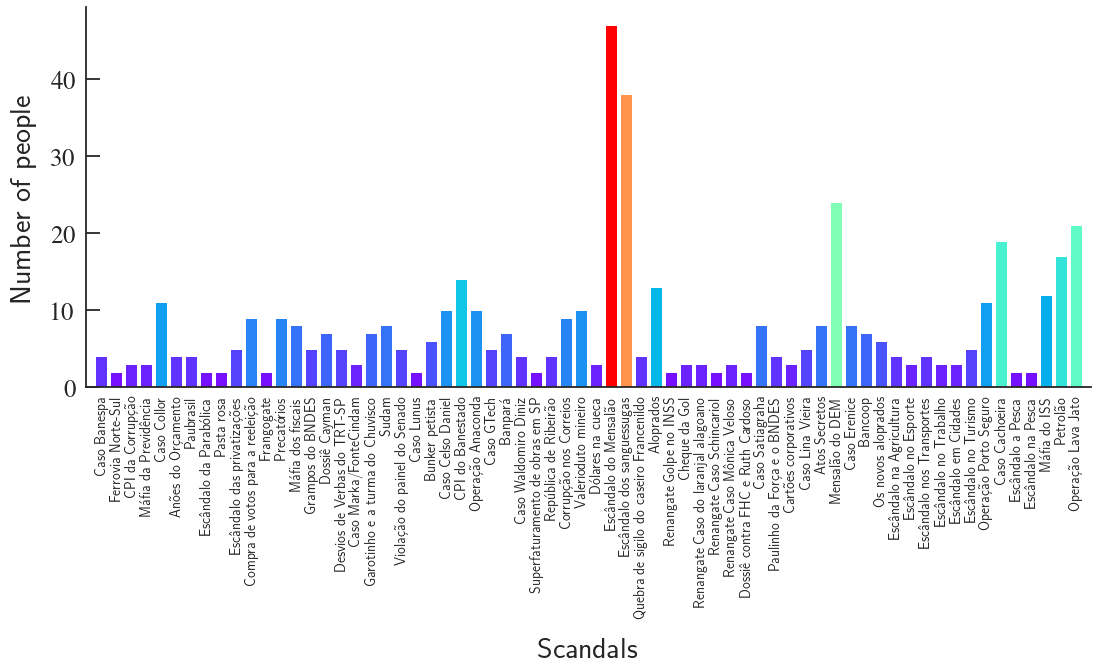

In [15]:
fig, ax = plt.subplots(figsize=(18,7))
y=df_size['size'].values.astype(int)
x=np.array(df_size.index)

norm = mpl.colors.Normalize(vmin=1, vmax=max(y))
cmap = plt.cm.rainbow
m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cmaplist = [m.to_rgba(i) for i in y]
ax.bar(x,y,color=cmaplist)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x',length=0)
# ax.tick_params(axis="x",length=0,direction="in", pad=-200)

ax.set_xlim(-1,66)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
labels=["",""]
labels.extend(list(df_size.scandal))
ax.set_xticklabels(labels,rotation=90,fontsize=14)
ax.set_ylabel(r"Number of people")
ax.set_xlabel(r"Scandals")

# Scandal size distribution

In [37]:
bins, densities=cdf(df_size['size'], nbins=15, log=False, surv=True)

In [38]:
loc, scale = stats.expon.fit(df_size['size'], floc=0)

(2.0, 5.424242424242424)


Text(0.5, 0, 'Degree, $k$')

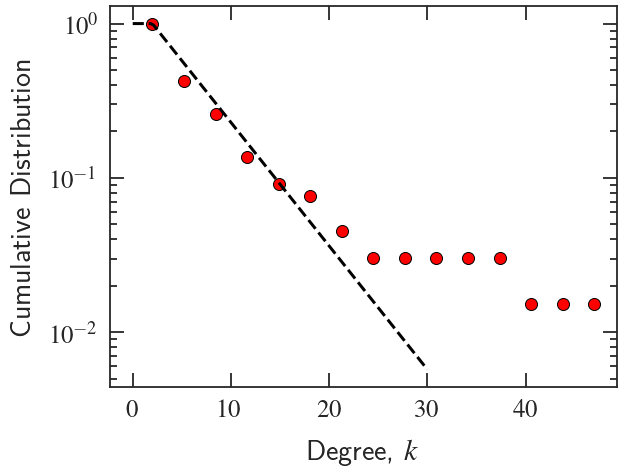

In [41]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(bins, densities,
        marker='o',
        color='r',
        markeredgecolor='k',
        markersize=12,
        linewidth=0)

rX = np.linspace(0,30, 100)
params = stats.expon.fit(df_size['size'])
rP=1-stats.expon.cdf(rX, *params)
print(params)
ax.plot(rX, rP,'k--',linewidth=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.set_yscale('log')
ax.set_ylabel(r"Cumulative Distribution")
ax.set_xlabel(r"Degree, $k$")

# Number of people investigated over time

In [18]:
df=df_size.groupby('year').sum().reset_index()
df.head()

,year,size
0,1987,6
1,1988,3
2,1991,3
3,1992,11
4,1993,8


In [19]:
x,y=df.year,df['size']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(slope, intercept, r_value, p_value, std_err )

def f_linear(x,slope, intercept):
    y=intercept+slope*x
    return y

1.1727945005728568 -2327.818560566607 0.5484637080966225 0.004528762927255238 0.372826654569419


Text(0.5, 0, 'Time, $t$')

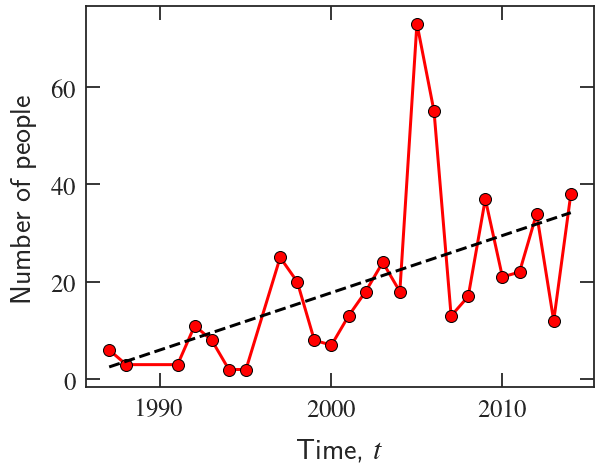

In [20]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, y,
        marker='o',
        color='r',
        markeredgecolor='k',
        markersize=12,
        linewidth=3)

xr=np.arange(1987,2015,1)

ax.plot(x, f_linear(x,slope, intercept),
        marker='o',
        color='k',
        linestyle='dashed',
        markeredgecolor='k',
        markersize=0,
        linewidth=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))


ax.set_ylabel(r"Number of people")
ax.set_xlabel(r"Time, $t$")

# Autocorrelation 

In [21]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [22]:
results=[]
for i in range(0,5000):
    yrand=np.random.choice(y,len(y))
    results.extend(autocorr(yrand)[2:])

In [23]:
yinf,ysup=df.quantile(.025),df.quantile(.995)
print(yinf,ysup)

year    1987.6
size       2.0
Name: 0.025, dtype: float64 year    2013.88
size      70.84
Name: 0.995, dtype: float64


Text(0.5, 0, 'Lag, $\\tau$')

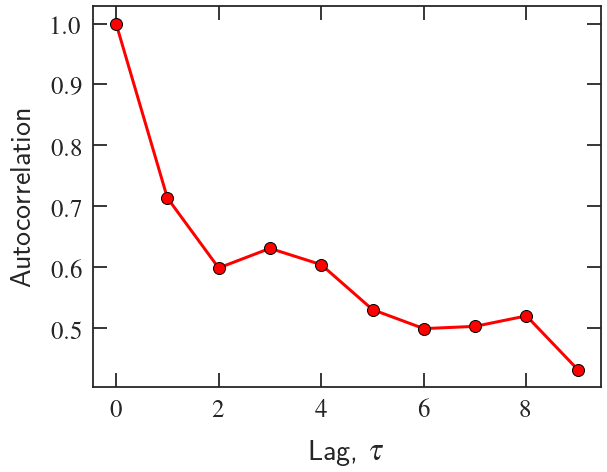

In [24]:
fig, ax = plt.subplots(figsize=figsize)
xauto=np.arange(0,10,1)
yaut=autocorr(y)[:10]
ax.plot(xauto,yaut/max(yaut),
        marker='o',
        color='r',
        markeredgecolor='k',
        markersize=12,
        linewidth=3)
# ax.fill_between(xauto, yinf/max(yaut), ysup/max(yaut),color='gray')

ax.set_ylabel(r"Autocorrelation")
ax.set_xlabel(r"Lag, $\tau$")

# Load data

In [25]:
df_net=pd.read_csv("data/edge_list.csv")[['Source','Target']]
df_net.head()

,Source,Target
0,246,243
1,246,60
2,246,240
3,246,242
4,246,241


# Corruption network 

In [26]:
G=nx.Graph()
G.add_edges_from(df_net.values)

In [27]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 404
Number of edges: 3549
Average degree:  17.5693


/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


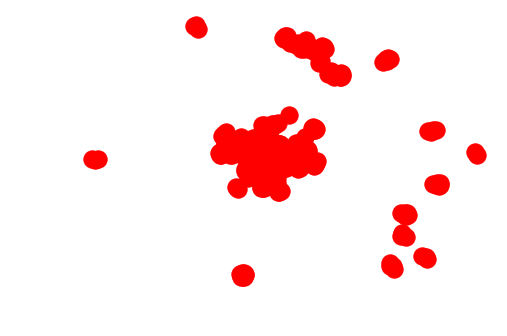

In [28]:
nx.draw(G,pos=nx.spring_layout(G))

# Structural properties

In [60]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 404
Number of edges: 3549
Average degree:  17.5693


In [61]:
G_erdos_renyi=nx.erdos_renyi_graph(404,p=2*3549/(404**2))
print(nx.info(G_erdos_renyi))

Name: 
Type: Graph
Number of nodes: 404
Number of edges: 3488
Average degree:  17.2673


In [62]:
G_rand=G.copy()
nx.double_edge_swap(G_rand,nswap=1000,max_tries=10000)

In [143]:
np.average(list(dict(G.degree()).values()))

17.56930693069307

In [157]:
print('assortativity_coefficient - empirical',
      nx.degree_assortativity_coefficient(G))
print('assortativity_coefficient - configuration',
      nx.degree_assortativity_coefficient(G_rand))
print('assortativity_coefficient - random graph',
      nx.degree_assortativity_coefficient(G_erdos_renyi))

assortativity_coefficient - empirical 0.5985375644805349
assortativity_coefficient - configuration 0.2931872203152471
assortativity_coefficient - random graph -0.04286793122729269


In [158]:
print('average_clustering - empirical',
      nx.average_clustering(G))
print('average_clustering - configuration',
      nx.average_clustering(G_rand))
print('average_clustering - random graph',
      nx.average_clustering(G_erdos_renyi))

average_clustering - empirical 0.925765588813958
average_clustering - configuration 0.20854657466463675
average_clustering - random graph 0.044317481502266026


In [159]:
print('global_efficiency - empirical',
      nx.global_efficiency(G))
print('global_efficiency - configuration',
      nx.global_efficiency(G_rand))
print('global_efficiency - random graph',
      nx.global_efficiency(G_erdos_renyi))

global_efficiency - empirical 0.2344131648187608
global_efficiency - configuration 0.41790899933714004
global_efficiency - random graph 0.4461464756899308


In [160]:
gcc=sorted(nx.connected_components(G),key=len,reverse=True)[0]
sp=nx.average_shortest_path_length(nx.subgraph(G,gcc))
print('average_shortest_path_length - empirical',sp)

gcc=sorted(nx.connected_components(G_rand),key=len,reverse=True)[0]
sp=nx.average_shortest_path_length(nx.subgraph(G_rand,gcc))
print('average_shortest_path_length - configuration',sp)

gcc=sorted(nx.connected_components(G_erdos_renyi),key=len,reverse=True)[0]
sp=nx.average_shortest_path_length(nx.subgraph(G_erdos_renyi,gcc))
print('average_shortest_path_length - random graph',sp)

average_shortest_path_length - empirical 2.990018072542344
average_shortest_path_length - configuration 2.6260963565339166
average_shortest_path_length - random graph 2.4093678598629094


# Degree distribution 

In [30]:
degree_sequence = [d for n, d in G.degree()] # degree sequence

Text(0.5, 0, 'Degree, $k$')

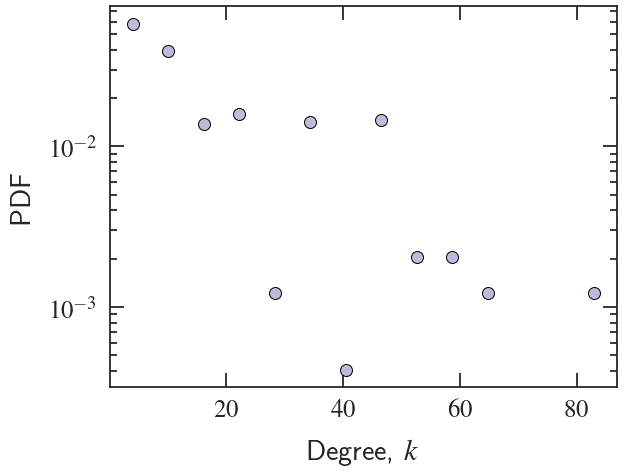

In [31]:
fig, ax = plt.subplots(figsize=figsize)
bins, densities=pdf(np.array(degree_sequence),log=False)
ax.plot(bins, densities,
        marker='o',
        color='#bebada',
        markeredgecolor='k',
        markersize=12,
        linewidth=0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

ax.set_yscale('log')
ax.set_ylabel(r"PDF")
ax.set_xlabel(r"Degree, $k$")

In [32]:
loc, scale = stats.expon.fit(degree_sequence, floc=0)

(1.0, 16.56930693069307)


Text(0.5, 0, 'Degree, $k$')

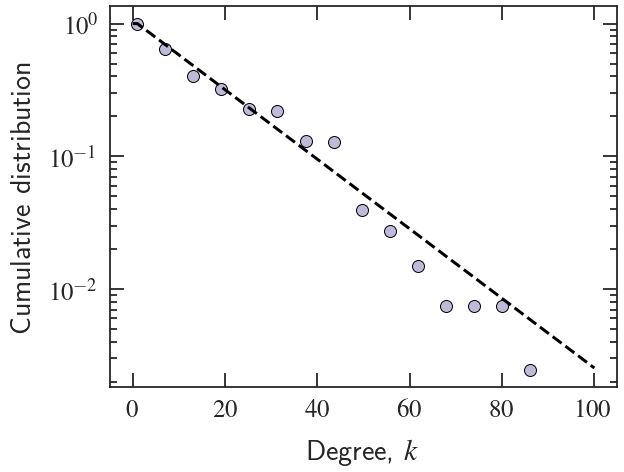

In [42]:
fig, ax = plt.subplots(figsize=figsize)
bins, densities=cdf(np.array(degree_sequence))
ax.plot(bins, densities,
        marker='o',
        color='#bebada',
        markeredgecolor='k',
        markersize=12,
        linewidth=0)

rX = np.linspace(0,100, 100)
params = stats.expon.fit(degree_sequence)
rP=1-stats.expon.cdf(rX, *params)
print(params)
ax.plot(rX, rP,'k--',linewidth=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

ax.set_yscale('log')
ax.set_ylabel(r"Cumulative distribution")
ax.set_xlabel(r"Degree, $k$")

# Centrality distribution

In [71]:
btw=nx.betweenness_centrality(G)
btw_rand=nx.betweenness_centrality(G_rand)
btw_er=nx.betweenness_centrality(G_erdos_renyi)


In [72]:
btw_sequence = list(btw.values() )# betweenness sequence
btw_sequence_rand = list(btw_rand.values() )# betweenness sequence
btw_sequence_er = list(btw_er.values() )# betweenness sequence

Text(0.5, 0, 'Betweenness, $b$')

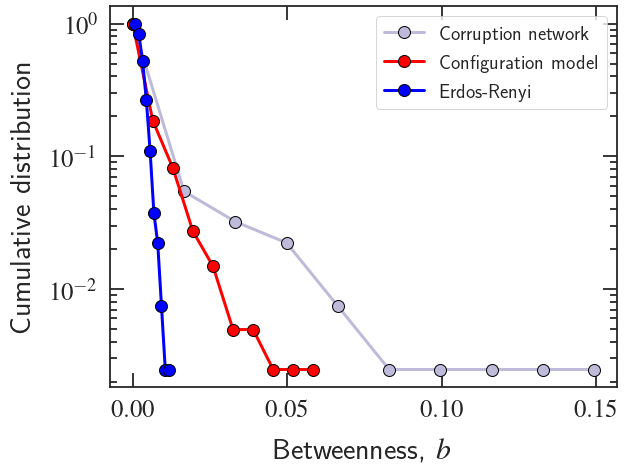

In [74]:
fig, ax = plt.subplots(figsize=figsize)
bins, densities=cdf(np.array(btw_sequence),nbins=10,log=False)
ax.plot(bins, densities,
        marker='o',
        color='#bebada',
        markeredgecolor='k',
        markersize=12,
        linewidth=3,
       label='Corruption network')

bins, densities=cdf(np.array(btw_sequence_rand),nbins=10,log=False)
ax.plot(bins, densities,
        marker='o',
        color='r',
        markeredgecolor='k',
        markersize=12,
        linewidth=3,
       label='Configuration model')

bins, densities=cdf(np.array(btw_sequence_er),nbins=10,log=False)
ax.plot(bins, densities,
        marker='o',
        color='b',
        markeredgecolor='k',
        markersize=12,
        linewidth=3,
       label='Erdos-Renyi')

ax.legend(fontsize=20)
ax.set_yscale('log')
ax.set_ylabel(r"Cumulative distribution")
ax.set_xlabel(r"Betweenness, $b$")

# Community structure

## Louvain 

`$ pip install community`

`$ pip install python-louvain`

In [23]:
import community

partition = community.best_partition(G)

Number of partitions:26


/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecation

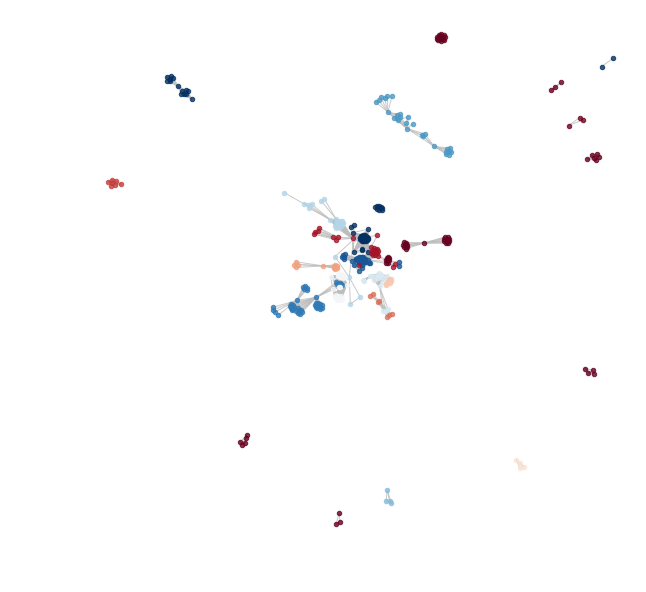

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

print('Number of partitions:{}'.format(len(set(partition.values()))))
# NETWORK     
node_size=(np.array(list(dict(G.degree()).values())))/5
node_size[node_size<3]=3

cmap =plt.get_cmap('RdBu_r') 
cNorm  = colors.Normalize(vmin=min(node_size), vmax=max(node_size))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)


pos=nx.spring_layout(G)
count = 0.
for i in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == i]
    k = G.subgraph(list_nodes)
    colorVal = scalarMap.to_rgba(i)
    nx.draw(k,
            pos=pos,
            node_color=mpl.colors.rgb2hex(colorVal),
            node_size=20,
            edge_color='#bdbdbd', 
            width=1, 
            edge_cmap=plt.cm.winter,
            with_labels=False,
            font_size=10,
            color="k",
            alpha=0.8)


## Netcarto: Community structure and node's role
http://seeslab.info/downloads/network-cartography-netcarto/

In [25]:
df_net.head()

,Source,Target
0,246,243
1,246,60
2,246,240
3,246,242
4,246,241


In [26]:
def netcarto(net,weight=False):
    """
    Executes netcarto in C, see netcarto documentation

    """
    import subprocess
    path_in='c/netcarto/net.dat'
    path_out='c/netcarto/net.dat.log'

    #Save network
    net.to_csv(path_in, header=None, index=None, sep='\t',encoding='utf-8')

    #Run netcarto
    command= './c/netcarto/netcarto -f {0} -r -o {1}'.format(path_in,path_out)
    if weight==True:
        command= './c/netcarto/netcarto -f {0} -r -w -o {1}'.format(path_in,path_out)
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process.wait()

    #Read netcarto results
    netcarto_result= pd.read_csv(path_out,skiprows=[0,1],sep='\t',encoding='utf-8')
    netcarto_result.rename(columns={netcarto_result.columns[0]: "Label"},inplace=True)
    netcarto_result.fillna(0,inplace=True)
    netcarto_result.sort_values("Role",inplace=True,ascending=False)
    process.wait()

    #Remove files
    #os.system('rm '+path_in)
    #os.system('rm '+path_out)
    print("Netcarto done!")
    return netcarto_result


def plot_background_netcarto(ax,ymin=-3,ymax=4):
    alpha=0.5

    #R1
    x=np.array([-0.01, 0.05])
    y1=[ymin for i in range(0,len(x))]
    y2=[2.5 for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#cccccc', interpolate=True,alpha=alpha) #gray

    #R2
    x=np.array([0.05,0.62])
    y1=[ymin for i in range(0,len(x))]
    y2=[2.5 for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#ef3b2c', interpolate=True,alpha=alpha) #red

    #R3
    x=np.array([0.62, 0.8])
    y1=[ymin for i in range(0,len(x))]
    y2=[2.5 for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#74c476', interpolate=True,alpha=alpha) #green

    #R4
    x=np.array([0.8, 1])
    y1=[ymin for i in range(0,len(x))]
    y2=[2.5 for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#6baed6', interpolate=True,alpha=alpha) #blue

    #R5
    x=np.array([-0.01, 0.3])
    y1=[2.5 for i in range(0,len(x))]
    y2=[ymax for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#fee090', interpolate=True,alpha=alpha) #yellow

    #R6
    x=np.array([0.3, 0.75])
    y1=[2.5 for i in range(0,len(x))]
    y2=[ymax for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#8c510a', interpolate=True,alpha=alpha) #brown

    #R7
    x=np.array([0.75, 1])
    y1=[2.5 for i in range(0,len(x))]
    y2=[ymax for i in range(0,len(x))]
    ax.fill_between(x,y1,y2, facecolor='#c994c7', interpolate=True,alpha=alpha) #pink


    ax.set_xlim(0,1)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(r'Participation coefficient, $P$')
    ax.set_ylabel(r'Within-module, $Z$')

In [27]:
resultnetcarto=netcarto(df_net,weight=False)

Netcarto done!


In [28]:
resultnetcarto.head()

,Label,Module,Connectivity,Participation,Role
150,117,14,2.593094,0.465028,R6
141,112,14,2.593094,0.000000,R5
104,168,18,6.083618,0.161633,R5
50,273,8,3.464102,0.000000,R5
139,124,14,2.593094,0.283419,R5


In [29]:
set(list(resultnetcarto.Module))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

(-0.01, 1.0)

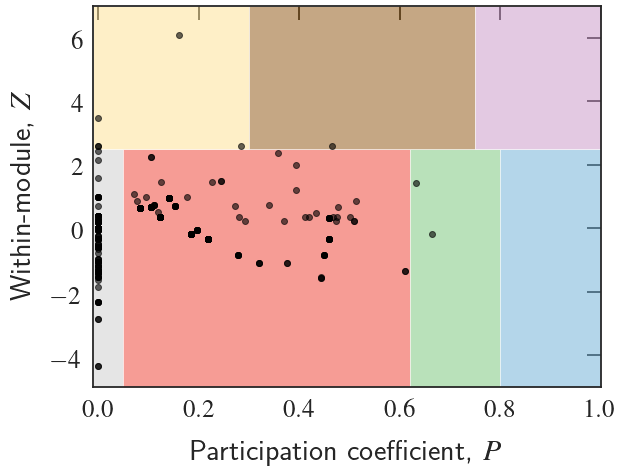

In [30]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(resultnetcarto.Participation,resultnetcarto.Connectivity,"ko",alpha=0.6)#,markersize=12)
plot_background_netcarto(ax, ymin=-5, ymax=7)
ax.set_ylim(-5,7)
ax.set_xlim(-0.01,1.00)

In [31]:
roles=sorted(list(set(resultnetcarto.Role)))
sizes=[50,70,100,300,600]
D=dict()
for i,role in enumerate(roles):
    D[role]=sizes[i]

Number of partitions:21


/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecation

(-0.9871882997120419,
 0.7896063004073669,
 -1.060002959117719,
 1.1072308490673706)

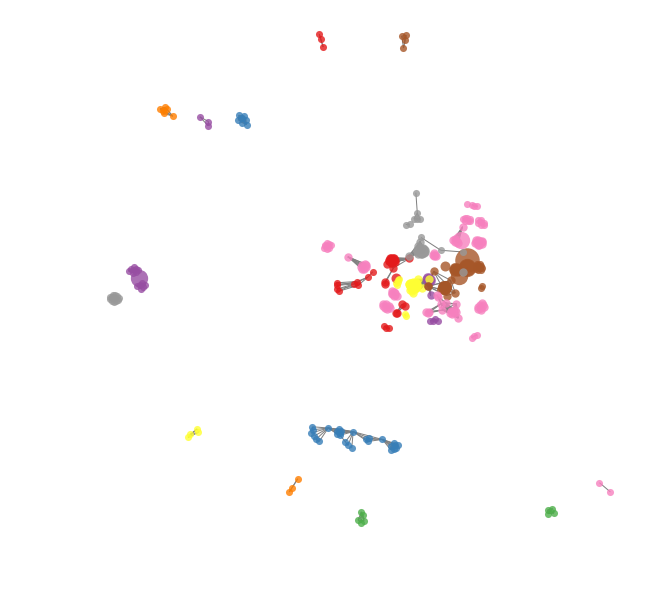

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

# NETWORK     
number_of_modules=len(pd.unique(resultnetcarto.Module))
print('Number of partitions:{}'.format(number_of_modules))

pos=nx.spring_layout(G)


cmap =plt.get_cmap('Set1') 
cNorm  = colors.Normalize(vmin=0, vmax=number_of_modules)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

for i in range(0,number_of_modules):
    k = G.subgraph(list(resultnetcarto[resultnetcarto.Module==i].Label))
    
    for role in roles:
        subk = k.subgraph(list(resultnetcarto[resultnetcarto.Role==role].Label))
        colorVal = scalarMap.to_rgba(i)
        nx.draw_networkx_nodes(subk,
                pos=pos,
                #node_shape=shapes[role],
                node_color=mpl.colors.rgb2hex(colorVal),
                node_size=D[role],
                linewidths=0,
                with_labels=False,
                font_size=10,
                color="k",
                alpha=0.8)
        nx.draw_networkx_edges(subk,pos=pos,edge_color='gray')
ax.axis('off')